# Image Segmentation for Ceramic Grains

## Data Preparation

We are going to retrieve our dataset images (4 training and 1 validation) and convert them to a gray-scale pixel matrix. We will assume that all input images are in gray-scale as this is a proof of concept and can easily be transferred to multiple color panes.

We are going to transform the input images to 1600 x 1600 pixels to make it square while not losing any grain boundary data as the boundary can be quite thin sometimes. We will downsample this with max-pooling later on in our CNN.

Then we will perform data augmentations to produce more samples (positional augmentation, color/hue augmentations, etc.).

In [12]:
from pathlib import Path
from PIL import Image
from matplotlib.pyplot import imshow
import torch
import numpy as np
from typing import Tuple, Dict, List
from torchvision.transforms import v2 as T
from torchvision.transforms.v2 import functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [3]:
orig_res = (1600, 1200)
data_res = (1600, 1600)

to_image_tensor = T.ToImage()
resize_to_square = T.Resize(size=data_res, interpolation=T.InterpolationMode.NEAREST_EXACT, antialias=False)
to_grayscale = T.Grayscale(num_output_channels=1)
normalize_scale = T.ToDtype(torch.float32, scale=True)

prepare_transform = T.Compose([
  to_image_tensor,
  resize_to_square,
  to_grayscale,
  normalize_scale,
])

expand_scale = T.ToDtype(torch.uint8, scale=True)
resize_to_original = T.Resize(size=orig_res, interpolation=T.InterpolationMode.NEAREST_EXACT, antialias=False)
to_pil_image = T.ToPILImage(mode='L')

output_transform = T.Compose([
  expand_scale,
  resize_to_original,
  to_pil_image
])

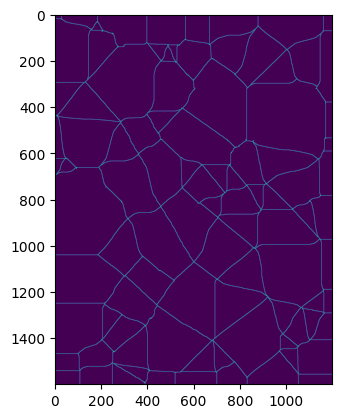

In [4]:
train_path = './grain_segmentation_data/train/'
train_x, train_y = [], []
for i in range(4):
  img = prepare_transform(Image.open(f'{train_path}/Images/{i}.png'))
  seg = prepare_transform(Image.open(f'{train_path}/Segmentations/{i}.png'))
  train_x.append(img)
  train_y.append(seg)

imshow(output_transform(train_y[1]))

In [5]:
class CustomImageDataset(Dataset):
  def __init__(self, dir: str, transform=None) -> None:
    self.img_paths = list((Path(dir) / 'Images').glob("*.png"))
    self.seg_paths = list((Path(dir) / 'Segmentations').glob("*.png"))

    assert len(self.img_paths) == len(self.seg_paths)

    self.transform = transform
  
  def __len__(self) -> int:
    return len(self.img_paths)

  def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
    img = Image.open(self.img_paths[idx])
    seg = Image.open(self.seg_paths[idx])

    if self.transform:
      img = self.transform(img)
      seg = self.transform(seg)

    return img, seg

In [6]:
train_data = CustomImageDataset(dir='./grain_segmentation_data/train/', transform=prepare_transform)
val_data = CustomImageDataset(dir='./grain_segmentation_data/validation/', transform=prepare_transform)

In [7]:
train_dataloader = DataLoader(dataset=train_data, batch_size=1, num_workers=0, shuffle=True)
val_dataloader = DataLoader(dataset=val_data, batch_size=1, num_workers=0, shuffle=False)

## Model

In [43]:
class DoubleConvolution(nn.Module):
  def __init__(self, in_channels: int, out_channels: int) -> None:
    super().__init__()
    
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3)
    self.act1 = nn.ReLU()
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3)
    self.act2 = nn.ReLU()

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.conv1(x)
    x = self.act1(x)
    x = self.conv2(x)
    x = self.act2(x)
    return x

In [44]:
class DownSample(nn.Module):
  def __init__(self) -> None:
    super().__init__()

    self.pool = nn.MaxPool2d(2)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.pool(x)
    return x

In [45]:
class UpSample(nn.Module):
  def __init__(self, in_channels: int, out_channels: int) -> None:
    super().__init__()

    self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
  
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.upconv(x)
    return x

In [49]:
class CropAndConcat(nn.Module):
  def forward(self, x: torch.Tensor, skip_x: torch.Tensor) -> torch.Tensor():

    skip_x = F.center_crop(skip_x, [x.shape[2], x.shape[3]])
    x = torch.cat([x, skip_x], dim=1)
    return x

In [54]:
class UNet(nn.Module):
  def __init__(self, in_channels: int, out_channels: int) -> None:
    super().__init__()

    self.down_conv = nn.ModuleList([DoubleConvolution(i, o) for i, o in [(in_channels, 64), (64, 128), (128, 256), (256, 512)]])
    self.down_sample = nn.ModuleList([DownSample() for _ in range(4)])
    self.middle_conv = DoubleConvolution(512, 1024)
    self.up_sample = nn.ModuleList([UpSample(i, o) for i, o in [(1024, 512), (512, 256), (256, 128), (128, 64)]])
    self.up_conv = nn.ModuleList([DoubleConvolution(i, o) for i, o in [(1024, 512), (512, 256), (256, 128), (128, 64)]])
    self.concat = nn.ModuleList([CropAndConcat() for _ in range(4)])
    self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
  
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    skips = []
    for i in range(len(self.down_conv)):
      x = self.down_conv[i](x)
      skips.append(x)
      x = self.down_sample[i](x)
    x = self.middle_conv(x)
    for i in range(len(self.up_conv)):
      x = self.up_sample[i](x)
      x = self.concat[i](x, skips.pop())
      x = self.up_conv[i](x)
    x = self.final_conv(x)
    return x
    

In [55]:
model = UNet(1, 1)
output_mask = model.forward(train_data[0][0].view(1, 1, 1600, 1600))

In [59]:
output_mask

tensor([[[[0.0663, 0.0670, 0.0667,  ..., 0.0667, 0.0666, 0.0668],
          [0.0663, 0.0665, 0.0668,  ..., 0.0664, 0.0659, 0.0658],
          [0.0667, 0.0673, 0.0671,  ..., 0.0664, 0.0666, 0.0671],
          ...,
          [0.0669, 0.0660, 0.0655,  ..., 0.0660, 0.0663, 0.0663],
          [0.0675, 0.0674, 0.0660,  ..., 0.0671, 0.0668, 0.0668],
          [0.0662, 0.0668, 0.0660,  ..., 0.0660, 0.0658, 0.0671]]]],
       grad_fn=<ConvolutionBackward0>)